# Import Required Libraries
Import the necessary libraries, including pandas and sqlite3.

In [25]:
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway"),
    ("databases_uc/ubereats.db", "ubereats")
]
print(db_files)


for db_file, db_id in db_files:
    print(f"Inspecting schema for {db_file}...")
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables: {tables}")
    
    if ('restaurants',) in tables:
        cursor.execute("SELECT sql FROM sqlite_master WHERE name='restaurants';")
        schema = cursor.fetchone()[0]
        print(f"Schema for 'restaurants':\n{schema}")
    else:
        print("No 'restaurants' table found.")
    
    conn.close()


[('databases_uc/deliveroo.db', 'deliveroo'), ('databases_uc/takeaway.db', 'takeaway'), ('databases_uc/ubereats.db', 'ubereats')]
Inspecting schema for databases_uc/deliveroo.db...
Tables: [('locations',), ('restaurants',), ('categories',), ('menu_items',), ('locations_to_restaurants',)]
Schema for 'restaurants':
CREATE TABLE restaurants(
                      id INTEGER PRIMARY KEY,
                      name TEXT,
                      visited_time,
                      latitude,
                      longitude,
                      menu_id,
                      category TEXT,
                      address TEXT,
                      postal_code,
                      prep_time,
                      delivery_time,
                      delivery_fee,
                      fulfillment_method,
                      min_order,
                      phonenumber,
                      rating,
                      rating_number,
                      uname
                      )
Inspec

# Define Database Connection
Establish a connection to the SQLite database using sqlite3.

In [26]:
import os
import sqlite3
import pandas as pd

def load_restaurant_data(db_file, db_id, c, m=50):
    """Load and calculate weighted ratings for restaurant data from specified database."""
    if not os.path.exists(db_file):
        print(f"Error: {db_file} does not exist.")
        return pd.DataFrame()

    queries = {
        "deliveroo": f"""
            SELECT 
                name AS restaurant_name, 
                address, postal_code, uname,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating, CAST(rating_number AS INTEGER) AS rating_number,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0
        """,
        "takeaway": f"""
            SELECT 
                r.name AS restaurant_name, 
                r.address, r.city, r.primarySlug AS restaurant_id,
                CAST(r.longitude AS REAL) AS longitude, 
                CAST(r.latitude AS REAL) AS latitude, 
                r.ratings AS rating, CAST(r.ratingsNumber AS INTEGER) AS rating_number,
                ((r.ratingsNumber * r.ratings) + ({m} * {c})) / (r.ratingsNumber + {m}) AS weighted_rating,
                l.postalCode AS postal_code
            FROM restaurants r
            LEFT JOIN (
                SELECT
                    lr.restaurant_id, l.postalCode
                FROM locations_to_restaurants lr
                JOIN locations l ON lr.location_id = l.ID
                WHERE l.postalCode IS NOT NULL
            ) l ON r.primarySlug = l.restaurant_id
            WHERE r.ratings IS NOT NULL AND r.ratingsNumber > 0
        """,
        "ubereats": f"""
            SELECT 
                title AS restaurant_name, 
                location__address AS address, location__city AS city,
                CAST(location__longitude AS REAL) AS longitude, 
                CAST(location__latitude AS REAL) AS latitude, 
                rating__rating_value AS rating, CAST(rating__review_count AS INTEGER) AS rating_number,
                ((rating__review_count * rating__rating_value) + ({m} * {c})) / (rating__review_count + {m}) AS weighted_rating
            FROM restaurants
            WHERE rating__rating_value IS NOT NULL AND rating__review_count > 0
        """
    }

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(queries[db_id], conn)
        if df.empty:
            print(f"Warning: No data from {db_id}.")
        df['longitude'] = df['longitude'].round(6)
        df['latitude'] = df['latitude'].round(6)
        df['source'] = db_id
        return df
    except sqlite3.OperationalError as e:
        print(f"Error with {db_id}: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

# Define database files and identifiers
db_files = [
    ("databases_uc/deliveroo.db", "deliveroo"),
    ("databases_uc/takeaway.db", "takeaway"),
    ("databases_uc/ubereats.db", "ubereats")
]

# Load and combine data
dataframes = [load_restaurant_data(file, db_id, c=4.0, m=50) for file, db_id in db_files]
stacked_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values
stacked_df['city'] = stacked_df.get('city', pd.Series()).fillna("Unknown")
stacked_df['postal_code'] = stacked_df.get('postal_code', pd.Series()).fillna("Unknown")
stacked_df['address'] = stacked_df['address'].fillna("Unknown")
stacked_df['rating'] = stacked_df['rating'].fillna(0.0)


# Drop duplicates based on restaurant_name, address, rating and source
stacked_df = stacked_df.drop_duplicates(subset=['restaurant_name', 'address', 'rating_number', 'source'])

# Sort the DataFrame by weighted_rating in descending order
stacked_df = stacked_df.sort_values(by='weighted_rating', ascending=False)

# Display the updated DataFrame
print(f"Total rows after dropping duplicates: {stacked_df.shape[0]}")
stacked_df = stacked_df.sort_values(by='weighted_rating', ascending=False)

# Display the sorted DataFrame
stacked_df.head()


Total rows after dropping duplicates: 6413


,restaurant_name,address,postal_code,uname,longitude,latitude,rating,rating_number,weighted_rating,source,city,restaurant_id
59738,De Echte Eethuis Carlos,Herseltsesteenweg 207,2230,NaN,4.835920,51.002308,5.0,599,4.922958,takeaway,Aarschot,eethuis-carlos-aarschot
8438,Veziroglu,Franklin Rooseveltlaan 100,1800,NaN,4.425172,50.931044,5.0,455,4.900990,takeaway,Vilvorde,veziroglu
2633,Snack Thieffry,Rue Pervyse 62,1140,NaN,4.399869,50.830792,4.9,3875,4.888535,takeaway,1040,snack-thieffry
4068,Sushiline,Chaussée De Louvain 470,1140,NaN,4.391012,50.853172,4.9,3036,4.885418,takeaway,Bruxelles,sushiline-bruxelles
60904,Snack Dekan,Place Cardinal Mercier 41,1731,NaN,4.329693,50.880092,4.9,2845,4.884456,takeaway,Jette,snack-dekan


In [27]:
stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6413 entries, 59738 to 36061
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   restaurant_name  6413 non-null   object 
 1   address          6413 non-null   object 
 2   postal_code      6413 non-null   object 
 3   uname            1690 non-null   object 
 4   longitude        6413 non-null   float64
 5   latitude         6413 non-null   float64
 6   rating           6413 non-null   float64
 7   rating_number    6413 non-null   int64  
 8   weighted_rating  6413 non-null   float64
 9   source           6413 non-null   object 
 10  city             6413 non-null   object 
 11  restaurant_id    3630 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 651.3+ KB


In [28]:
stacked_df.describe()

,longitude,latitude,rating,rating_number,weighted_rating
count,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000
mean,4.232581,50.873525,4.143162,277.557617,4.088563
std,0.605866,2.704579,0.492332,546.730799,0.302121
min,0.000000,0.000000,1.100000,3.000000,1.823523
25%,3.828770,50.865096,3.900000,27.000000,3.957143
50%,4.386802,51.027893,4.200000,88.000000,4.096774
75%,4.454160,51.205250,4.500000,315.000000,4.270330
max,5.865305,51.530875,5.000000,10368.000000,4.922958


# Top Pizza Restaurants Per Delivery App 



In [29]:
# Filter for pizza restaurants
pizza_restaurants = stacked_df[stacked_df['restaurant_name'].str.contains('pizza', case=False, na=False)]

# Get top 5 pizza restaurants per delivery app based on weighted rating
top_pizza_per_app = pizza_restaurants.groupby('source').apply(lambda x: x.nlargest(5, 'weighted_rating')).reset_index(drop=True)

# Display the top pizza restaurants per delivery app
print("Top Pizza Restaurants Per Delivery App:")
print(top_pizza_per_app[['restaurant_name', 'address', 'city', 'rating', 'rating_number', 'weighted_rating', 'source']])

Top Pizza Restaurants Per Delivery App:
            restaurant_name                                           address  \
0             Plant a Pizza                                       49 Geldmunt   
1     Piano A apulian pizza                                    Ravenstraat 38   
2    Pizza Hut Sint Truiden                                    Kennedylaan 9a   
3                 Pizza Hut                             Place de St-Job 38/39   
4     Pizza Borsalino Heule                                     2 Heuleplaats   
5              Pizza Minute                                Rue des palais 146   
6                Pizza Heat                                    Molenstraat 95   
7        Pizza Time Evergem                                        Eindeken 9   
8     Kebap - Pizza De Brug                           Sint-Truidersteenweg 46   
9           Pink Pizza Genk                                   Stalenstraat 27   
10        Pizza Hut - Evere   ChaussÃ©e De Louvain 874, Evere, Bruxel

C:\Users\Becode-son\AppData\Local\Temp\ipykernel_10628\1510857816.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pizza_per_app = pizza_restaurants.groupby('source').apply(lambda x: x.nlargest(5, 'weighted_rating')).reset_index(drop=True)


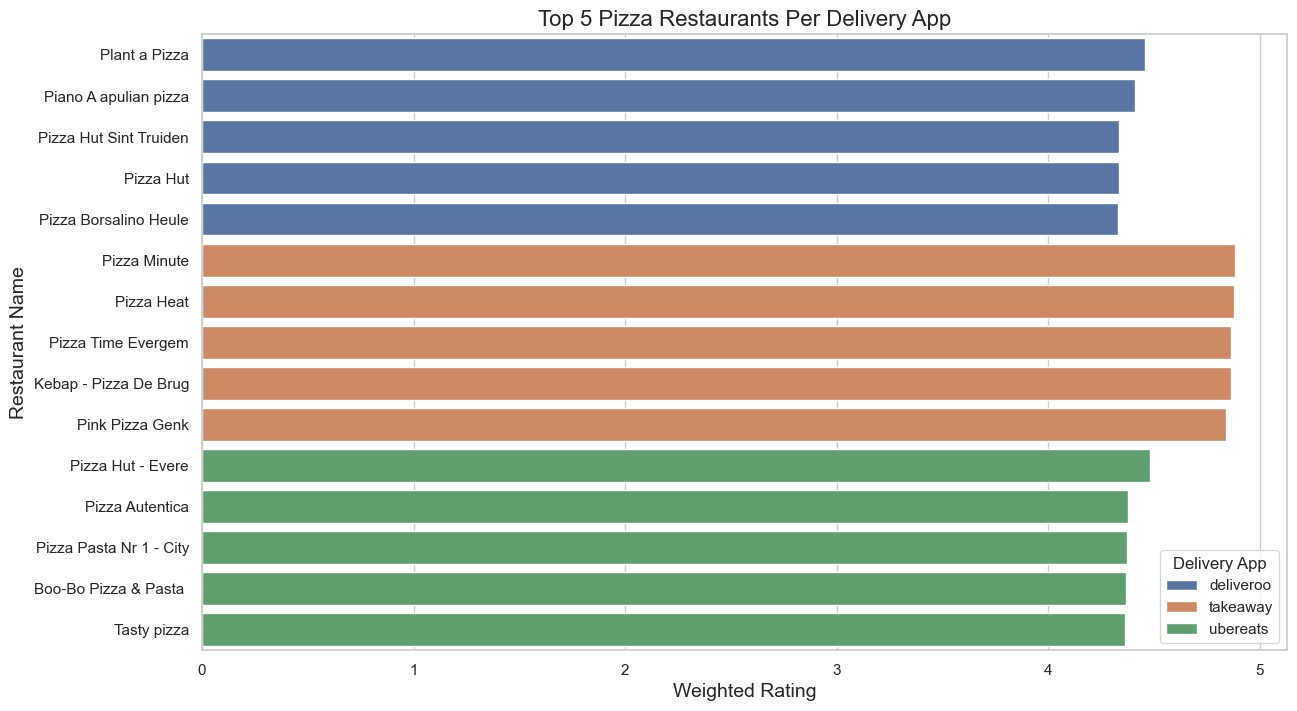

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot for the top 5 pizza restaurants per delivery app
plt.figure(figsize=(14, 8))
sns.barplot(x='weighted_rating', y='restaurant_name', hue='source', data=top_pizza_per_app, dodge=False)

# Add titles and labels
plt.title('Top 5 Pizza Restaurants Per Delivery App', fontsize=16)
plt.xlabel('Weighted Rating', fontsize=14)
plt.ylabel('Restaurant Name', fontsize=14)

# Display the legend
plt.legend(title='Delivery App', loc='lower right')

# Show the plot
plt.show()

# Rating Distributions per App 

In [31]:
import sqlite3
import pandas as pd

# Step 1: Load Databases
deliveroo_db = 'databases_uc/deliveroo.db'
takeaway_db = 'databases_uc/takeaway.db'
ubereats_db = 'databases_uc/ubereats.db'

# Step 2: Function to Fetch Restaurant Ratings from Each Database
def fetch_restaurant_ratings(db_file, db_id):
    conn = sqlite3.connect(db_file)
    query = None
    if db_id == "deliveroo":
        query = """
        SELECT name AS restaurant_name, rating, CAST(rating_number AS INTEGER) AS rating_count
        FROM restaurants
        WHERE rating IS NOT NULL AND rating_number > 0;
        """
    elif db_id == "takeaway":
        query = """
        SELECT name AS restaurant_name, ratings AS rating, CAST(ratingsNumber AS INTEGER) AS rating_count
        FROM restaurants
        WHERE ratings IS NOT NULL AND ratingsNumber > 0;
        """
    elif db_id == "ubereats":
        query = """
        SELECT title AS restaurant_name, rating__rating_value AS rating, CAST(rating__review_count AS INTEGER) AS rating_count
        FROM restaurants
        WHERE rating__rating_value IS NOT NULL AND rating__review_count > 0;
        """
    else:
        return pd.DataFrame()  # Return empty DataFrame if db_id is invalid
    df = pd.read_sql_query(query, conn)
    conn.close()
    df['source'] = db_id
    return df

# Step 3: Fetch Data from All Platforms
df_deliveroo = fetch_restaurant_ratings(deliveroo_db, "deliveroo")
df_takeaway = fetch_restaurant_ratings(takeaway_db, "takeaway")
df_ubereats = fetch_restaurant_ratings(ubereats_db, "ubereats")

# Combine data into one DataFrame
df_ratings = pd.concat([df_deliveroo, df_takeaway, df_ubereats], ignore_index=True)

# Step 4: Normalize Restaurant Names for Cross-Platform Comparison
df_ratings['restaurant_name_clean'] = df_ratings['restaurant_name'].str.lower().str.strip()

# Analysis 1: Rating Distribution Across Platforms
rating_distribution = df_ratings.groupby('source')['rating'].describe()
print("Rating Distribution Across Platforms:")
print(rating_distribution)


Rating Distribution Across Platforms:
            count      mean       std  min  25%  50%  75%  max
source                                                        
deliveroo  1690.0  4.181361  0.344459  1.2  4.0  4.2  4.4  5.0
takeaway   3630.0  4.079449  0.558046  1.4  3.8  4.2  4.5  5.0
ubereats   1093.0  4.295700  0.407181  1.1  4.1  4.4  4.6  5.0


In [32]:
#Cross-Platform Restaurants (gebaseerd op cleaning v/d naam, strip en lower)

# Filter restaurants that appear on multiple platforms
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Create a pivot table for comparing ratings
cross_platform_pivot = cross_platform.pivot_table(
    index='restaurant_name_clean', 
    columns='source', 
    values='rating', 
    aggfunc='mean'
).dropna()

print("\nCross-Platform Rating Comparison:")
print(cross_platform_pivot)


# Create a pivot table for comparing rating counts
cross_platform_count_pivot = cross_platform.pivot_table(
    index='restaurant_name_clean', 
    columns='source', 
    values='rating_count', 
    aggfunc='mean'
).dropna()

print("\nCross-Platform Rating Count Comparison:")
print(cross_platform_count_pivot)


Cross-Platform Rating Comparison:
source                 deliveroo  takeaway  ubereats
restaurant_name_clean                               
acqua e farina               4.3      4.50       4.2
africalicious                3.1      3.70       4.3
amvrosia                     4.6      4.40       4.8
annapurna                    4.2      4.10       4.9
au pain marie                4.6      4.60       4.4
...                          ...       ...       ...
wok & walk                   4.1      3.40       4.2
wok masala                   4.4      4.40       4.5
wolfgang                     4.5      4.10       4.0
yammi yammi                  4.1      4.20       3.9
yokoso                       4.3      4.55       4.5

[114 rows x 3 columns]

Cross-Platform Rating Count Comparison:
source                 deliveroo  takeaway  ubereats
restaurant_name_clean                               
acqua e farina              28.0     143.0      48.0
africalicious               14.0     328.0      55.0

    Rating Differences Across Platforms:
        UberEats has the highest average rating (4.30), indicating greater customer satisfaction.
        Deliveroo has a moderate average rating (4.18), showing consistency.
        Takeaway has the lowest average rating (4.08) with higher variability, indicating mixed customer experiences.

    Review Count Variations:
        Takeaway generally has the most reviews, indicating a larger or more engaged customer base compared to Deliveroo and UberEats.
        UberEats tends to have fewer reviews but higher ratings, suggesting selective or more positive feedback.

    Top Restaurants:
        The top-rated restaurants are mostly from Takeaway, especially those with high review counts.
        Deliveroo and UberEats have top-rated restaurants, but with fewer reviews, indicating potential for growth in popularity.

    Cross-Platform Variability:
        Some restaurants have significantly different ratings across platforms, indicating differences in customer demographics or service quality.


In [33]:
# Analysis 2: Cross-Platform Comparison for Similar Restaurants
# Filter restaurants that appear on multiple platforms
cross_platform = df_ratings.groupby('restaurant_name_clean').filter(lambda x: x['source'].nunique() > 1)

# Create a pivot table for comparing ratings and review counts
cross_platform_pivot = cross_platform.pivot_table(
    index='restaurant_name_clean', 
    columns='source', 
    values=['rating', 'rating_count'], 
    aggfunc='mean'
).dropna()

print("\nCross-Platform Rating and Review Count Comparison:")
print(cross_platform_pivot)

# Combine cross-platform ratings and review counts into a single DataFrame
cross_platform_combined = cross_platform_pivot.reset_index()
cross_platform_combined.columns = ['restaurant_name_clean', 'rating_deliveroo', 'rating_takeaway', 'rating_ubereats', 'rating_count_deliveroo', 'rating_count_takeaway', 'rating_count_ubereats']

# Display the combined DataFrame
print("\nCross-Platform Ratings and Review Counts:")
print(cross_platform_combined)



Cross-Platform Rating and Review Count Comparison:
                         rating                   rating_count           \
source                deliveroo takeaway ubereats    deliveroo takeaway   
restaurant_name_clean                                                     
acqua e farina              4.3     4.50      4.2         28.0    143.0   
africalicious               3.1     3.70      4.3         14.0    328.0   
amvrosia                    4.6     4.40      4.8        500.0    532.0   
annapurna                   4.2     4.10      4.9        109.0     90.0   
au pain marie               4.6     4.60      4.4        500.0    273.0   
...                         ...      ...      ...          ...      ...   
wok & walk                  4.1     3.40      4.2         80.0    954.0   
wok masala                  4.4     4.40      4.5         99.0     90.0   
wolfgang                    4.5     4.10      4.0         49.0     69.0   
yammi yammi                 4.1     4.20      3.